# K-Means Application: Data Preprocessing


We can use clustering as a data preprocessing step before applying a supervised learning algorithm. For example, clustering can be used to perform **dimensionality reduction**.


### How does the K-Means algorithm perform dimensionality reduction?

First, we cluster a high-dimensional feature vector using the K-Means algorithm. The result is a set of k cluster centers.

Then, we represent each of the original data points in terms of how far it is from each of these cluster centers. That is, we can compute the distance of a data point to each cluster center. The result is a **set of k distances for each data point**.

These k distances can form a new vector of dimension k. 

Finally, we represent our original data as a new vector of lower dimension, relative to the original feature dimension.


#### Dimensionality Reduction of a Handwritten Digits Dataset

We perform K-Means dimesionality reduction on a high-dimentional handwritten digits dataset. Then, we classify the dataset using a standard supervised algorithm.

Our goal is to see whether we can improve classification accuracy by using K-Means as a preprocessing step.

In [1]:
from time import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

## Dataset

We will use a handwritten digits dataset.

It has 1,797 images. 

Each image is grayscale 8 x 8 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has **64 features**.

First, we load the data directly from cloud using Scikit-Learn.

In [2]:
X_digits, y_digits = load_digits(return_X_y=True)

print(X_digits.shape)

(1797, 64)


## Display a Random Image

To display a digit, we need to reshape an instance’s feature vector to a 8 x 8 array.

For displaying we use Matplotlib’s imshow() function.

We see that there are white numbers on a black background, each thickly written just in the middle and they are quite low resolution (8 x 8 pixels).

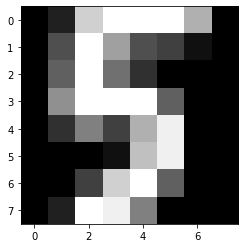

In [3]:
random_digit = X_digits[32]

random_digit_image = random_digit.reshape(8, 8)

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
#plt.axis("off")
plt.show()

## Visualize A Number With Pixel Values

Let's visualize the above number with its pixel values.

Note that the images are grayscale. Before plotting the grayscale pixel values we need to understand the grayscale image format.

### Grayscale Image Format

A grayscale (or graylevel) image is simply one in which the only colors are shades of gray. The reason for differentiating such images from any other sort of color image is that less information needs to be provided for each pixel.

In fact a 'gray' color is one in which the red, green and blue components all have equal intensity in RGB space, and so it is only necessary to specify a single intensity value for each pixel, as opposed to the three intensities needed to specify each pixel in a full color image.

For a grayscale images, the pixel value is a single number that represents the brightness of the pixel. The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255.

Typically 0 is taken to be black, and 255 is taken to be white. Values in between make up the different shades of gray.

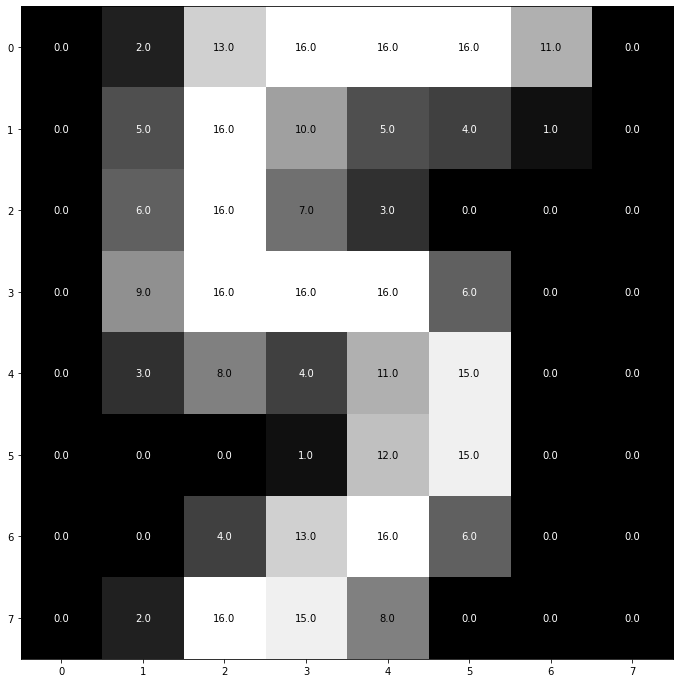

In [4]:
# Visualize a number with its pixel values
def visualize_input(img):
    fig = plt.figure(figsize = (12,12)) 
    img = img.reshape(8, 8)
    plt.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            plt.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

visualize_input(X_digits[32])

## Create Train and Test Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

print("Dimension of X_train: ", X_train.shape)

Dimension of X_train:  (1347, 64)


## Classification Model: Logistic Regression

We use Logistic Regression to classify the data and use its accuracy as our baseline for comparison.

First, we classify the data without any preprocessing.

Then, we preprocess the data and perform classification.

Finally, we evaluate the impact of preprocessing by comparing the accuracies.

In [6]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

accuracy_before_preprocessing = log_reg.score(X_test, y_test)

print("Accuracy (before preprocessing): ", accuracy_before_preprocessing)

Accuracy (before preprocessing):  0.9688888888888889


## Preprocessing by K-Means + Classification

Our goal is to see whether we can improve classification accuracy by using K-Means as a preprocessing step.

We reduce the dimension of the features by using K-Means.

- Step 1: Choose a number of clusters to be the projected dimension of our features and train the K-Means model.
- Step 2: Compute the distance of the data points from each cluster center. These distances will be the new feature vector.

        Note that we need to compute the new features for both the training and test dataset after fitting the model with the training data.



In [7]:
# Step 1: Choose a number of clusters to be the projected dimension of our features and train the K-Means model.
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X_train)


# Step 2: Compute the distance of the data points from each cluster center. 
#         These distances will be the new feature vector.
X_train_new = kmeans.transform(X_train)
X_test_new = kmeans.transform(X_test)

print("\nDimension of the New Features: ", X_train_new.shape)

# Classify the data using the new features
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_new, y_train)


accuracy_after_preprocessing = log_reg.score(X_test_new, y_test)
print("\nAccuracy (after preprocessing): ", accuracy_after_preprocessing)


Dimension of the New Features:  (1347, 50)

Accuracy (after preprocessing):  0.9777777777777777


## Preprocessing by K-Means + Classification using a Pipeline

We can perform the preprocessing (two steps) and classification by creating a pipeline.

In [8]:
t0 = time()

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

print("Preprocessing + Training Complete in %0.3fs" % (time() - t0))

accuracy_after_preprocessing = pipeline.score(X_test, y_test)

print("\nAccuracy (after preprocessing): ", accuracy_after_preprocessing)

reduction_in_error = 1 - (1 - accuracy_after_preprocessing) / (1 - accuracy_before_preprocessing)
print("Reduction in Error Rate: %f" %  reduction_in_error)

Preprocessing + Training Complete in 4.850s

Accuracy (after preprocessing):  0.9777777777777777
Reduction in Error Rate: 0.285714


## Observation

The error rate is reduced by more than 28%! 

However, note that we chose the number of clusters $k$ completely arbitrarily.

We can perform a grid search to find the optimal value for $k$ that results in the best classification performance.

## Grid Search for the Optimal Value of $k$

In [9]:
%%time

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_clf.fit(X_train, y_train)


params_optimal_grid_clf = grid_clf.best_params_

print("Optimal Hyperparameter Values: ", params_optimal_grid_clf)
print("Grid Accuracy: ", grid_clf.score(X_test, y_test))
print("\n")

Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:  3.9min finished


Optimal Hyperparameter Values:  {'kmeans__n_clusters': 93}
Grid Accuracy:  0.98


CPU times: user 23.2 s, sys: 1.14 s, total: 24.3 s
Wall time: 4min


## Preprocessing by Optimal Number of $k$ + Classification

In [10]:
print("Optimal Number of Clusters: ", params_optimal_grid_clf['kmeans__n_clusters'])

t0 = time()

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=params_optimal_grid_clf['kmeans__n_clusters'], random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

print("Preprocessing + Training Complete in %0.3fs" % (time() - t0))

accuracy_after_preprocessing = pipeline.score(X_test, y_test)

print("\nAccuracy (after preprocessing): ", accuracy_after_preprocessing)

reduction_in_error = 1 - (1 - accuracy_after_preprocessing) / (1 - accuracy_before_preprocessing)
print("Reduction in Error Rate: %f" %  reduction_in_error)

Optimal Number of Clusters:  93
Preprocessing + Training Complete in 5.341s

Accuracy (after preprocessing):  0.98
Reduction in Error Rate: 0.357143


## Observation: Grid Search


After using the optimal number of $k$, error rate is reduced by more than 35%!

However, the dimension of the features actually incresed from 64 to 93. So, it is not technically dimensionality "reduction".

We increased the performance by projecting the features on a different space that has more dimension.
